In [1]:
import utils
reload(utils)

from utils import Preproc_v2, LoopyBPInference_v2, get_image, grid_plot, feat_repr, gabor_repr, draw_graph, \
    learn_feature_laterals, suppress_explained_locs, get_slide_info, _trans_frcs, \
    calculate_reconstruction_error, get_bp_info, forward_pass_v2, render_sparse, get_slide_pos_from_contour, \
    animate_belief_progation

from science_rcn.inference import dilate_2d, get_tree_schedule, recount
from science_rcn.learning import sparsify, learn_laterals, make_adjacency_graph, \
    add_underconstraint_edges, adjust_edge_perturb_radii

import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import networkx as nx
import glob
import os
import itertools
import pickle
import copy
from time import time
from multiprocessing import Pool
from functools import partial
from scipy.spatial import distance

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from collections import namedtuple
ModelFactors = namedtuple('ModelFactors', 'frcs edge_factors graph')

In [2]:
def get_bu_msgs(img, sparse, hierarchy_below, td_msgs=None, f1_bu_msg=None, feat_presence=None):
    bu_msgs = []
    
    for layer_num, hierarchy in enumerate(hierarchy_below, 1):
        if layer_num == 1:
            if f1_bu_msg is None:
                bu_msg = Preproc_v2(cross_channel_pooling=True).fwd_infer(img)
            else:
                bu_msg = f1_bu_msg.copy()
            
            explained_locs = [loc for _, backtrace_positions in sparse for loc in backtrace_positions]
            suppress_explained_locs(bu_msg, explained_locs, suppress_radius=hierarchy['suppress_radius'])
        elif layer_num >= 2:
            layer_features = hierarchy['features']
            pool_shape, stride, threshold, n_iters = hierarchy['infer_params']
            contour_hint = hierarchy['contour_hint']
            only_fids = hierarchy.get('only_fids')
            default_score = -3
            
            messages = default_score*np.ones((len(layer_features), ) + bu_msg.shape[-2:], dtype=np.float32)
            for ifeat, feat_factors in enumerate(layer_features):
                if feat_presence is not None and not feat_presence[layer_num-1][ifeat]:
                    continue
                
                if only_fids is not None and ifeat not in only_fids:
                    continue
                
                frcs, edge_factors, graph = feat_factors
                tree_schedule = get_tree_schedule(frcs, graph)
                
                for trans_frcs, topleft_corner, feat_center, fbound in get_slide_info(
                    bu_msg, feat_factors, pool_shape, stride, contour_hint=contour_hint):
                    ic, jc = feat_center
                    score = forward_pass_v2(trans_frcs, bu_msg, graph, pool_shape, tree_schedule)
                    if score >= threshold.get(frcs.shape[0]):
                        score, bt_pos = get_bp_info(bu_msg, trans_frcs, edge_factors, pool_shape, n_iters)
                    messages[ifeat, ic, jc] = score if score >= threshold.get(frcs.shape[0]) else default_score
            bu_msg = messages
        
        if td_msgs is not None:
            bu_msg += td_msgs[layer_num-1]
        
        bu_msgs.append(bu_msg)
    return bu_msgs

def get_sparsification(img, sparse, hierarchy_below):
    sparse = copy.deepcopy(sparse)
    frcs = []
    if len(hierarchy_below) == 1:
        bu_msg = get_bu_msgs(img, sparse, hierarchy_below)[0]
        frcs = sparsify(bu_msg, suppress_radius=hierarchy_below[0]['suppress_radius'])
        return frcs
    else:
        features = hierarchy_below[-1]['features']
        _, _, threshold, _ = hierarchy_below[-1]['infer_params']
        while True:
            bu_msgs = get_bu_msgs(img, sparse, hierarchy_below)
            bu_msg = bu_msgs[-1]
            most_active_feature = np.unravel_index(bu_msg.argmax(), bu_msg.shape)
            ifeat, ic, jc = most_active_feature
            if bu_msg[ifeat, ic, jc] < threshold.get(features[ifeat][0].shape[0]):
                break
            
            backtrace_positions = backward_pass(bu_msgs, most_active_feature, hierarchy_below)
            sparse.append((None, backtrace_positions[0]))
            frcs.append(most_active_feature)
        return np.array(frcs)

def findPathsNoLC(G, u ,n):
    if n==0:
        return [[u]]
    paths = []
    for neighbor in G.neighbors(u):
        for path in findPathsNoLC(G,neighbor,n-1):
            if u not in path:
                paths.append([u]+path)
    return paths

def get_all_paths(graph, feat_size):
    path_length = feat_size - 1
    paths = []
    for node in graph:
        paths.extend(findPathsNoLC(graph, node, path_length))
    return paths

In [3]:
def propose_features(features, sparses, imgs,
                     hierarchy_below=[], max_dist=5, perturb_factor=2, feat_size=3, num_propose=10):
    proposed_feats = []
    max_edge_dist = max_dist + max_dist / float(perturb_factor)
    feats_dict = set()
    
    for _ in range(len(imgs)):
        choice = np.random.choice(len(imgs))
        img = imgs[choice]
        sparse = sparses[choice]
        
        bu_msgs = get_bu_msgs(img, sparse, hierarchy_below)
        frcs = get_sparsification(img, sparse, hierarchy_below)
        try:
            graph = make_adjacency_graph(frcs, bu_msgs[-1], max_dist=max_dist)
        except:
            continue
        
        for path in get_all_paths(graph, feat_size):
            if len(path) > 0 and any([
                distance.euclidean(frcs[path[i-1], 1:], frcs[path[i], 1:]) > max_edge_dist
                for i in range(1, len(path))]):
                continue
            
            feat = frcs[np.array(path)]
            topleft = feat[:, 1:].min(0)
            feat[:, 1:] = feat[:, 1:] - topleft
            feat = feat[feat[:, 1].argsort()]
            fid = tuple(feat.ravel())
            
            if fid in feats_dict:
                continue
            
            feats_dict.add(fid)
            feat_graph, edge_factors = learn_feature_laterals(feat, perturb_factor)
            feat_factors = ModelFactors(feat, edge_factors, feat_graph)
            proposed_feats.append(feat_factors)
        
        if len(proposed_feats) > num_propose:
            break
    
    np.random.shuffle(proposed_feats)
    
    return proposed_feats[:num_propose]

In [4]:
def found_features(img_sparse, features, hierarchy_below,
                   pool_shape=(25,25), stride=11, threshold=0.75, n_iters=10, contour_hint=None):
    img, sparse = img_sparse
    
    if len(hierarchy_below) == 2:
        hierarchy_below = copy.deepcopy(hierarchy_below)
        only_fids = np.concatenate([factors[0] for factors in features])
        only_fids = np.unique(only_fids[:, 0])
        hierarchy_below[-1]['only_fids'] = only_fids
    
    bu_msg = get_bu_msgs(img, sparse, hierarchy_below)[-1]
    
    founds = []
    for feat_factors in features:
        result = False
        
        frcs, edge_factors, graph = feat_factors
        tree_schedule = get_tree_schedule(frcs, graph)
        slide_info = get_slide_info(bu_msg, feat_factors, pool_shape, stride, contour_hint=contour_hint)
        
        for trans_frcs, topleft_corner, feat_center, fbound in slide_info:
            score = forward_pass_v2(trans_frcs, bu_msg, graph, pool_shape, tree_schedule)
            if score >= threshold.get(frcs.shape[0]):
                score, bt_pos = get_bp_info(bu_msg, trans_frcs, edge_factors, pool_shape, n_iters)
            if score >= threshold.get(frcs.shape[0]):
                result = True
                break
        founds.append(result)
    return founds

In [5]:
def is_duplicated(feat1_factors, feat2_factors, hierarchy_below,
                  pool_shape=(5,5), stride=1, padding_factor=3, n_iters=4, threshold=0.75):
    feat1, _, _ = feat1_factors
    feat2, _, _ = feat2_factors
    feat1_bound = feat1[:, -2:].max(0) + 1
    feat2_bound = feat2[:, -2:].max(0) + 1
    size = max(feat1_bound[0], feat1_bound[1], feat2_bound[0], feat2_bound[1])
    
    num_channels = 16 if len(hierarchy_below)==1 else len(hierarchy_below[-1]['features'])
    cross_channel_pooling = True if len(hierarchy_below)==1 else False
    layer_bu_score = 1 if len(hierarchy_below)==1 else 3
    
    bu_msg = -np.ones((num_channels, padding_factor*size, padding_factor*size), dtype=np.float32)
    for f, r, c in feat1:
        fcs = [(f + offset) % num_channels for offset in (-1, 0, 1)] if cross_channel_pooling else [f]
        r_ = size + r
        c_ = size + c
        bu_msg[fcs, r_, c_] = layer_bu_score

    frcs, edge_factors, graph = feat2_factors
    tree_schedule = get_tree_schedule(frcs, graph)
    
    result = False
    for trans_frcs, topleft_corner, feat_center, fbound in get_slide_info(
        bu_msg, feat2_factors, pool_shape, stride):
        score = forward_pass_v2(trans_frcs, bu_msg, graph, pool_shape, tree_schedule)
        if score >= threshold.get(frcs.shape[0]):
            score, bt_pos = get_bp_info(bu_msg, trans_frcs, edge_factors, pool_shape, n_iters)
        if score >= threshold.get(frcs.shape[0]):
            result = True
            break
    return result

def remove_duplications(features, common_feats, hierarchy_below,
                        pool_shape=(5,5), stride=1, n_iters=4, threshold=0.75):
    common_feats = copy.deepcopy(common_feats)
    chosen = []
    while len(common_feats) > 0:
        idx, feat_factors, count = common_feats.pop(0)
        comparing_feat_factors = features + [factors for _, factors, _ in chosen]
        is_duplicated_feature = any([
            is_duplicated(feat_factors, chosen_feat_factors, hierarchy_below,
                          pool_shape=pool_shape, stride=stride, n_iters=n_iters, threshold=threshold)
            for chosen_feat_factors in comparing_feat_factors])
        
        if not is_duplicated_feature:
            chosen.append((idx, feat_factors, count))
    return chosen

In [6]:
def backward_pass(bu_msgs, most_active_feature, hierarchy_below):
    assert len(hierarchy_below) >= 2, 'backward pass need more than 2 layers'
    assert len(bu_msgs) == len(hierarchy_below), 'bu_msgs must have same length as hierarchy_below'
    
    ifeat, ic, jc = most_active_feature
    bu_msg = bu_msgs[-2]
    hierarchy = hierarchy_below[-1]
    
    frcs, edge_factors, graph = hierarchy['features'][ifeat]
    pool_shape, stride, threshold, n_iters = hierarchy['infer_params']
    trans_frcs = _trans_frcs(frcs, (ic, jc))
    score, backtrace_positions = get_bp_info(
        bu_msg, trans_frcs, edge_factors, pool_shape, n_iters)
    
    if len(hierarchy_below) == 2:
        return [backtrace_positions]
    elif len(hierarchy_below) == 3:
        f1_positions = []
        for most_active_child in backtrace_positions:
            positions = backward_pass(bu_msgs[:-1], most_active_child, hierarchy_below[:-1])
            f1_positions.append(positions[0])
        f1_positions = np.concatenate(f1_positions)
        return [f1_positions, backtrace_positions]
    else:
        raise('not supported')

def update_sparsification(updating_sparse, features, hierarchy_below,
                          pool_shape=(5,5), stride=4, threshold=0.75, n_iters=4, contour_hint=None):
    def _get_feat_presence(bu_msgs, hierarchy_below):
        feat_presence = []
        for layer_num, (bu_msg, hierarchy) in enumerate(zip(bu_msgs, hierarchy_below), 1):
            if layer_num == 1:
                presence = None
            else:
                pool_shape, stride, threshold, n_iters = hierarchy['infer_params']
                features = hierarchy['features']
                presence = [bu_msg[ifeat].max() >= threshold.get(frcs.shape[0])
                            for ifeat, (frcs, _, _) in enumerate(features)]
            feat_presence.append(presence)
        return feat_presence
    
    def _create_td_msgs(hierarchies, shape):
        channels = [16] + [len(hierarchy['features']) for hierarchy in hierarchies[1:]]
        return [np.zeros((channel,) + shape, dtype=np.float32) for channel in channels]
    
    def _update_td_msgs(td_msgs, backtrace_positions):
        layer_scores = [1, 3]
        for bt_pos, layer_score, td_msg in zip(backtrace_positions, layer_scores, td_msgs):
            for f, r, c in bt_pos:
                td_msg[f, r, c] = layer_score
    
    sparse = []
    isparse, img, feat_founds = updating_sparse
    hierarchy_learn = copy.deepcopy(hierarchy_below)
    hierarchy_learn.append({
        'features': copy.deepcopy(features),
        'infer_params': (pool_shape, stride, threshold, n_iters),
        'contour_hint': contour_hint
    })
    
    f1_bu_msg = Preproc_v2(cross_channel_pooling=True).fwd_infer(img)
    feat_presence = None
    td_msgs = _create_td_msgs(hierarchy_learn, f1_bu_msg.shape[-2:])
    
    while True:
        bu_msgs = get_bu_msgs(img, sparse, hierarchy_learn,
                              td_msgs=td_msgs, f1_bu_msg=f1_bu_msg, feat_presence=feat_presence)
        bu_msg = bu_msgs[-1]
        most_active_feature = np.unravel_index(bu_msg.argmax(), bu_msg.shape)
        ifeat, ic, jc = most_active_feature
        if bu_msg[ifeat, ic, jc] < threshold.get(features[ifeat][0].shape[0]):
            break
        
        backtrace_positions = backward_pass(bu_msgs, most_active_feature, hierarchy_learn)
        sparse.append((most_active_feature, backtrace_positions[0]))
        feat_presence = _get_feat_presence(bu_msgs, hierarchy_learn)
        
        _update_td_msgs(td_msgs, backtrace_positions)
    return (isparse, sparse)

In [7]:
# Dataset consist 10k .png images rendered from 3D objects in SHREC 2012
# dataset_dir = '/Users/annt/Downloads/SHREC_3D_2012/images/'
dataset_dir = '/home/ubuntu/downloads/images/'
n_procs = 36
seed = 2

dataset = sorted(glob.glob(dataset_dir + '*/*.png'))
np.random.seed(seed)
np.random.shuffle(dataset)

# Use first 500 images to learn F2 and F3-features in RCN
dataset = dataset[:500]

imgs = [get_image(file_path, size=(180, 180), padding=10) for file_path in dataset]
print len(imgs)

500


In [8]:
min_frac = 0.05
num_propose = 20
patience_max = 3

max_dist = 12
perturb_factor = 3
feat_sizes = (3, 5)

feat_size = feat_sizes[1]
patience = patience_max

# pool_shape = (5, 5)
# stride = 2
# threshold = {3: 2.5}
# n_iters = 10
# contour_hint = (3, 3)

pool_shape = (21, 21)
stride = 5
threshold = {5: 11.5, 4: 8.5, 3: 5.5}
n_iters = 30
contour_hint = (35, 35)

f2_features, _ = pickle.load(open('f2_features_r=3.pkl'))
hierarchy_below = [
    {'suppress_radius': 3},
    {'features': f2_features, 'infer_params': ((9,9), 2, {3: 2.5}, 10), 'contour_hint': (3,3)}
]


features = []
sparses = [[]]*len(imgs)
pool = Pool(processes=n_procs)

error = calculate_reconstruction_error(imgs, sparses, hierarchy_below)
interrupt_key = int(time())
print 'features: {}, error: {:.1f}'.format(len(features), error)
print 'interrupt_key: {}'.format(interrupt_key)
print

it = 0
while True:
    print '[{}]'.format(it)
    
    # propose features
    print 'propose',
    t = time()
    pfeats = propose_features(features, sparses, imgs,
                              hierarchy_below=hierarchy_below, max_dist=max_dist,
                              perturb_factor=perturb_factor, feat_size=feat_size,
                              num_propose=num_propose)
    dt1 = int(time() - t)
    print '{} ({}s)'.format(len(pfeats), dt1)
    
    # pick good candidates
    print 'chosen',
    t = time()
    partial_found_features = partial(found_features,
                                     features=pfeats, hierarchy_below=hierarchy_below,
                                     pool_shape=pool_shape, stride=stride, threshold=threshold,
                                     n_iters=n_iters, contour_hint=contour_hint)
    im_founds = pool.map(partial_found_features, zip(imgs, sparses))
    im_founds = np.array(im_founds, dtype=int)
    
    common_feats = sorted([
        (idx, pfeats[idx], count) for idx, count in enumerate(im_founds.sum(0))
        if count / float(len(imgs)) >= min_frac], key=lambda args: args[-1], reverse=True)
    
    unique_feats = remove_duplications(features, common_feats, hierarchy_below,
                                       pool_shape=pool_shape, stride=1, threshold=threshold, n_iters=n_iters)
    
    chosen = [feat_factors for idx, feat_factors, count in unique_feats]
    im_founds = im_founds[:, [idx for idx, feat_factors, count in unique_feats]]
    dt2 = int(time() - t)
    print '{} {} ({}s)'.format(len(common_feats), len(chosen), dt2)
    
    if not chosen:
        patience += -1
        
        print '[feat_size: {}, patience: {}]'.format(feat_size, patience)
        print
        
        if patience == 0:
            if feat_size > feat_sizes[0]:
                patience = patience_max
                feat_size += -1
            else:
                break
        
        continue
    
    features.extend(chosen)
    
    # re-compute sparse representation
    t = time()
    partial_update_sparsification = partial(update_sparsification,
                                            features=features, hierarchy_below=hierarchy_below,
                                            pool_shape=pool_shape, stride=stride, threshold=threshold,
                                            n_iters=n_iters, contour_hint=contour_hint)
    
    updating_args = [(isparse, imgs[isparse], feat_founds)
                     for isparse, feat_founds in enumerate(im_founds) if feat_founds.sum() > 0]
    
    print 'update', len(updating_args),
    for isparse, updated_sparse in pool.map(partial_update_sparsification, updating_args):
        sparses[isparse] = updated_sparse
    dt3 = int(time() - t)
    print '({}s)'.format(dt3)
    
    error = calculate_reconstruction_error(imgs, sparses, hierarchy_below)
    it += 1
    
    print 'features: {}, error: {:.1f}'.format(len(features), error)
    print
    
    # interrupt to debug
    try:
        with open('interrupt_key.txt') as fp:
            if int(fp.read()) == interrupt_key:
                break
    except:
        pass
    
pool.close()
pool.join()

features: 0, error: 615.9
interrupt_key: 1536659263

[0]
propose 20 (17s)
chosen 20 16 (62s)
update 382 (334s)
features: 16, error: 471.3

[1]
propose 20 (11s)
chosen 20 20 (158s)
update 350 (427s)
features: 36, error: 398.9

[2]
propose 20 (11s)
chosen 7 7 (131s)
update 297 (416s)
features: 43, error: 345.8

[3]
propose 20 (105s)
chosen 2 2 (55s)
update 78 (131s)
features: 45, error: 329.6

[4]
propose 20 (43s)
chosen 5 5 (93s)
update 89 (271s)
features: 50, error: 306.2

[5]
propose 20 (65s)
chosen 5 4 (152s)
update 155 (309s)
features: 54, error: 283.0

[6]
propose 20 (10s)
chosen 0 0 (33s)
[feat_size: 5, patience: 2]

[6]
propose 20 (49s)
chosen 0 0 (42s)
[feat_size: 5, patience: 1]

[6]
propose 20 (23s)
chosen 9 9 (177s)
update 168 (399s)
features: 63, error: 257.0

[7]
propose 20 (41s)
chosen 0 0 (37s)
[feat_size: 5, patience: 0]

[7]
propose 20 (29s)
chosen 5 4 (97s)
update 208 (447s)
features: 67, error: 228.8

[8]
propose 20 (62s)
chosen 0 0 (36s)
[feat_size: 4, patience: 2]



In [8]:
# pickle.dump((features, sparses), open('f3_features_r=3.pkl', 'wb'))

f2_features, _ = pickle.load(open('f2_features_r=3.pkl'))
features, sparses = pickle.load(open('f3_features_r=3.pkl'))

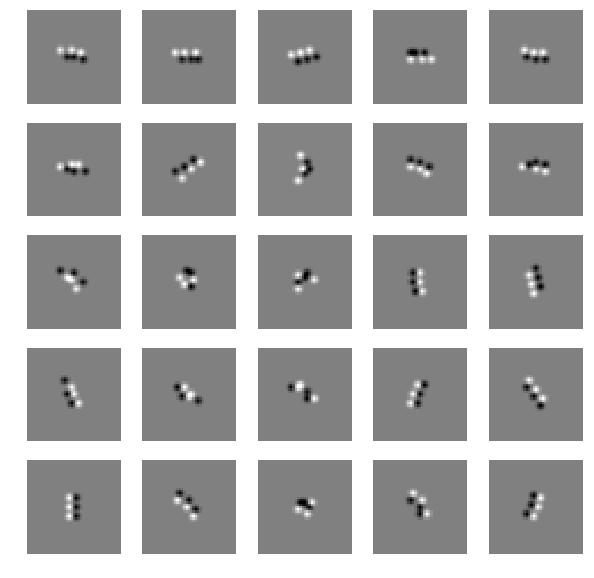

In [11]:
# F2 features

grid_plot([feat_repr(feat, shape=(41,41)) for feat in f2_features], size=2, ncols=5)

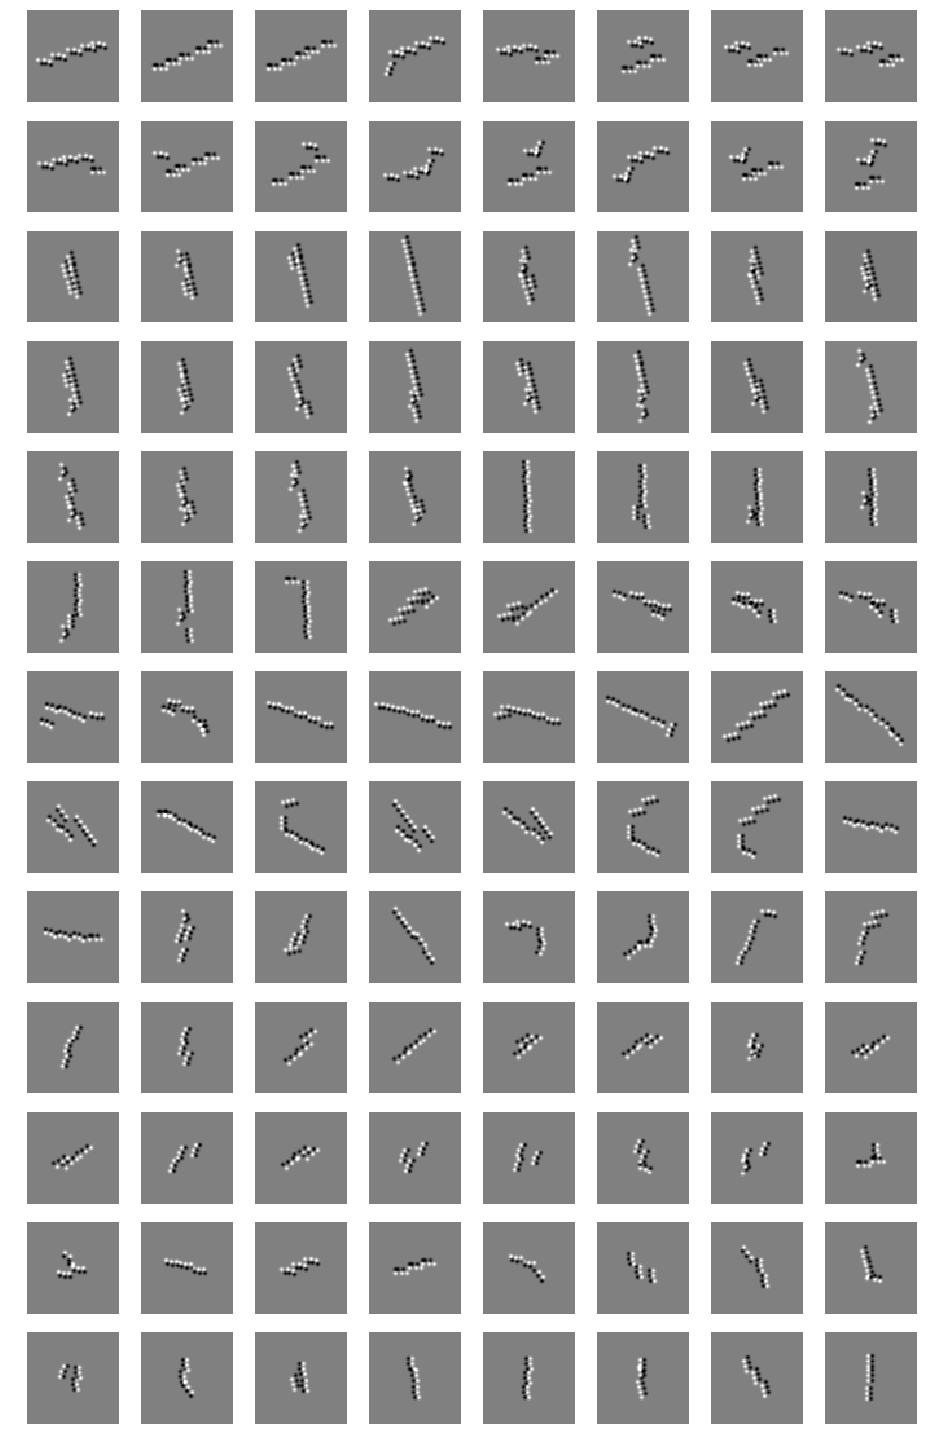

In [13]:
# Learning F3-features given F2-features already learned

grid_plot([feat_repr(feat, shape=(71,71), child_features=f2_features) for feat in features], size=2, ncols=8)

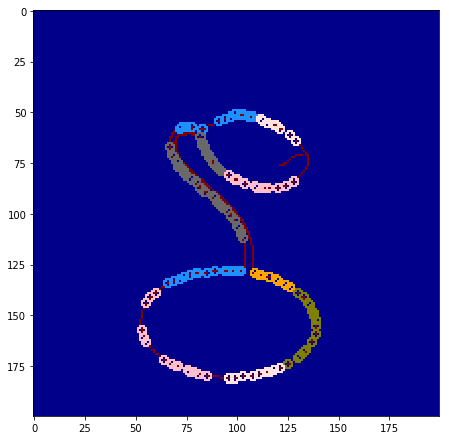

In [477]:
# Explain an image using F3-features

ids = np.random.randint(len(imgs), size=1)
grid_plot([render_sparse(imgs[i], sparses[i], features) for i in ids], size=8, ncols=2, axis=True)

In [70]:
# h = [
#     {'suppress_radius': 3},
#     {'features': f2_features, 'infer_params': ((9,9), 2, {3: 2.5}, 10), 'contour_hint': (3,3)}
# ]

# threshold = {5: 11.5, 4: 8.5, 3: 5.5}

In [69]:
# i = ids[0]
# print i
# isparse, sparse = update_sparsification((i, imgs[i], None), features, h,
#                                          pool_shape=(15,15), stride=5, threshold=threshold,
#                                          n_iters=30, contour_hint=(25,25))

# grid_plot([render_sparse(imgs[i], sparse, features)], size=6, axis=True)

In [180]:
# i = ids[0]
# bu_msgs = get_bu_msgs(imgs[i], [], hierarchy_below)
# frcs = get_sparsification(imgs[i], [], hierarchy_below)

# grid_plot([feat_repr((frcs,_,_), shape=(200,200))], size=8)

# pfeats = propose_features(features, [sparses[i]], [imgs[i]],
#                               hierarchy_below=hierarchy_below, max_dist=max_dist,
#                               perturb_factor=perturb_factor, feat_size=feat_size,
#                               num_propose=num_propose)

# grid_plot([feat_repr(feat, shape=(41,41)) for feat in pfeats], size=2, ncols=5)

In [179]:
# pool = Pool(processes=36)
# partial_found_features = partial(found_features,
#                                  features=pfeats, hierarchy_below=hierarchy_below,
#                                  pool_shape=pool_shape, stride=stride, threshold=threshold,
#                                  n_iters=n_iters, contour_hint=contour_hint)
# im_founds = pool.map(partial_found_features, zip(imgs, sparses))
# im_founds = np.array(im_founds, dtype=int)
# pool.close()
# pool.join()

In [178]:
# common_feats = sorted([
#         (idx, pfeats[idx], count) for idx, count in enumerate(im_founds.sum(0))
#         if count / float(len(imgs)) >= min_frac], key=lambda args: args[-1], reverse=True)

# unique_feats = remove_duplications(features, common_feats, hierarchy_below,
#                                        pool_shape=pool_shape, stride=1, threshold=threshold, n_iters=n_iters)
# print im_founds.sum(0)
# print len(common_feats), len(unique_feats)

In [21]:
# for idx1, pf in enumerate(pfeats):
#     for idx2, cfeat in enumerate(features):
#         if is_duplicated(cfeat, pf, hierarchy_below,
#                          pool_shape=(5,5), stride=1, n_iters=n_iters, threshold=threshold):
#             print idx1, idx2
#             grid_plot([feat_repr(feat, shape=(41,41)) for feat in [pf, cfeat]], size=2, ncols=10)
#             plt.show()
#             continue